In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression
from scipy.stats import boxcox_normmax, zscore
from sklearn.pipeline import Pipeline
from scipy.special import boxcox1p
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from scipy.stats import zscore
from sklearn.svm import SVR

#### This is my first stab at a decent regression problem.  I have seen notebooks online where people only used features more closely correlated with the target, which isn't something I wanted to do.  I felt I should use as much of the dataset as possible for the sake of experience.     

#### It is work in progress.  I would like to try this on a holdout test year (next week), at the minute all scores are based on a 30 / 70 split with random_state set @ 7.   

#### Taking the 2008 financial crisis into account could be a bad move.  This is only for practise and the features were taken into account with the sale price depending on current sale prices for that time.  The housing market was in a speculative bubble ffom the earliest year in this dataset, and prices didn't drop too much in 2008 here when compared to the rest of the sale dates. 81% of house prices in America were affected by the crisis and that does reflect *slightly* in this dataset, but, there are also some sales in the 500k - 800K regions of the sale price column to balance it out. The only thing I could do to mitigate the effects of the financial crisis would be to cap sale prices at below 500K, although I have tried that and it didn't make too much difference. Current skill level depicts what else I can do re: this issue right now, so I will make a return to that problem in future. 

#### Group-based imputation could be a good idea (as far as neighborhoond is concerned) so I will attempt to do this in the next couple of weeks. 

#### All manual ordinal encoding scrapped in favour of being handled by the LabelEncoder, and outlier treatment was also handled automatically. The same few problematic columns arose during the manual data analysis process and automating this feature results in a much smaller project, which takes a lot less time to run (without rendering the mass of relplots).  

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

Y = train['SalePrice']
train = train.drop(["Id", "SalePrice"], axis = 1)
test = test.drop(["Id"], axis = 1)

In [ ]:
train.shape, test.shape, Y.shape

((1460, 79), (1459, 79), (1460,))

In [ ]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [ ]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [ ]:
train.skew()

MSSubClass        1.407657
LotFrontage       2.163569
LotArea          12.207688
OverallQual       0.216944
OverallCond       0.693067
YearBuilt        -0.613461
YearRemodAdd     -0.503562
MasVnrArea        2.669084
BsmtFinSF1        1.685503
BsmtFinSF2        4.255261
BsmtUnfSF         0.920268
TotalBsmtSF       1.524255
1stFlrSF          1.376757
2ndFlrSF          0.813030
LowQualFinSF      9.011341
GrLivArea         1.366560
BsmtFullBath      0.596067
BsmtHalfBath      4.103403
FullBath          0.036562
HalfBath          0.675897
BedroomAbvGr      0.211790
KitchenAbvGr      4.488397
TotRmsAbvGrd      0.676341
Fireplaces        0.649565
GarageYrBlt      -0.649415
GarageCars       -0.342549
GarageArea        0.179981
WoodDeckSF        1.541376
OpenPorchSF       2.364342
EnclosedPorch     3.089872
3SsnPorch        10.304342
ScreenPorch       4.122214
PoolArea         14.828374
MiscVal          24.476794
MoSold            0.212053
YrSold            0.096269
dtype: float64

#### Dropping columns with more than 30% misising values, and dropping any duplicates:

In [ ]:
missing_values = train.isnull().sum() * 100 / len(train)
missing_values_df = pd.DataFrame({"Column": train.columns,
                                 "Percent missing": missing_values})

missing_values_df

,Column,Percent missing
MSSubClass,MSSubClass,0.000000
MSZoning,MSZoning,0.000000
LotFrontage,LotFrontage,17.739726
LotArea,LotArea,0.000000
Street,Street,0.000000
...,...,...
MiscVal,MiscVal,0.000000
MoSold,MoSold,0.000000
YrSold,YrSold,0.000000
SaleType,SaleType,0.000000


In [ ]:
train = train.dropna(thresh=0.70*len(train), axis=1)

In [ ]:
train.drop_duplicates(inplace=True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

#### Log-transform the target variable as it appears to be left-skewed: 

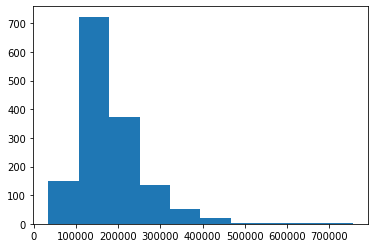

In [ ]:
plt.hist(Y)
plt.show() 

In [ ]:
Y = np.log(Y)

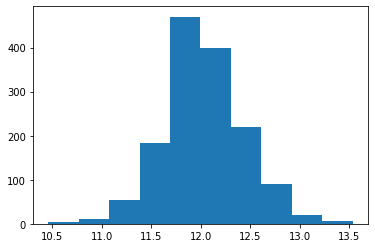

In [ ]:
plt.hist(Y)
plt.show() 

#### Get a handle on each unique data type in each column:

In [ ]:
for x in train.columns:
    print(f"{x}, {train[x].unique()}\n")

MSSubClass, [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]

MSZoning, ['RL' 'RM' 'C (all)' 'FV' 'RH']

LotFrontage, [ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.]

LotArea, [ 8450  9600 11250 ... 17217 13175  9717]

Street, ['Pave' 'Grvl']

LotShape, ['Reg' 'IR1' 'IR2' 'IR3']

LandContour, ['Lvl' 'Bnk' 'Low' 'HLS']

Utilities, ['AllPub' 'NoSeWa']

LotConfig, ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']

LandSlope, ['Gtl' 'Mod' 'Sev']

Neighborhood, ['CollgCr' 'Veenke

#### Find and impute missing values: 

In [ ]:
missing_values = train.isnull().sum() * 100 / len(train)

missing_values

MSSubClass        0.000000
MSZoning          0.000000
LotFrontage      17.739726
LotArea           0.000000
Street            0.000000
                   ...    
MiscVal           0.000000
MoSold            0.000000
YrSold            0.000000
SaleType          0.000000
SaleCondition     0.000000
Length: 74, dtype: float64

#### Filling Electrical and MasVnrType with their most common points, the apparent missing data points where the physical feature won't be present (no pool etc.) will be filled with "None" for object columns, and "0" for int columns, respectively:

In [ ]:
train["Electrical"].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [ ]:
train["MasVnrType"].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [ ]:
cols = ["GarageCond", "GarageQual", "GarageFinish", "LotFrontage", "GarageType", "BsmtCond", "BsmtExposure", "BsmtQual", "BsmtFinType2", "BsmtFinType1"]
train[cols] = train[cols].fillna("None")
cols = ["GarageYrBlt", "MasVnrArea", "BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "GarageCars"]
train[cols] = train[cols].fillna(0)
train["Electrical"] = train["Electrical"].fillna("SBrkr")
train["MasVnrType"] = train["MasVnrType"].fillna("None")

#### Source the object columns and label encode: 

In [ ]:
objects = [x for x in train if train[x].dtypes == "object"]

In [ ]:
for x in objects:
    le = LabelEncoder() 
    le.fit(list(train[x].values)) 
    train[x] = le.transform(list(train[x].values))

In [ ]:
train = train.astype(int)

In [ ]:
data_types = [x for x in train if train[x].dtypes != "int64"]

print(f"Number of columns consisting of data other than int64: {len(data_types)}")

Number of columns consisting of data other than int64: 0


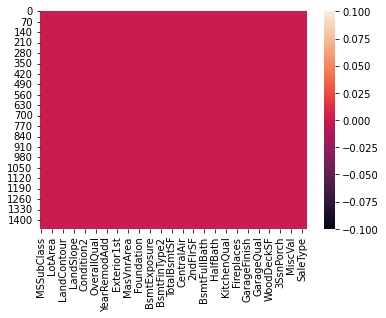

In [ ]:
sns.heatmap(train.isnull())
plt.show()

In [ ]:
null_sum = sum(x for x in train[x] == 'nan')

In [ ]:
print(f"Amount of null values remaining in dataset: {null_sum}")

Amount of null values remaining in dataset: 0


In [ ]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,75,8450,1,3,3,0,4,0,...,61,0,0,0,0,0,2,2008,8,4
1,20,3,90,9600,1,3,3,0,2,0,...,0,0,0,0,0,0,5,2007,8,4
2,60,3,78,11250,1,0,3,0,4,0,...,42,0,0,0,0,0,9,2008,8,4
3,70,3,70,9550,1,0,3,0,0,0,...,35,272,0,0,0,0,2,2006,8,0
4,60,3,94,14260,1,0,3,0,2,0,...,84,0,0,0,0,0,12,2008,8,4


#### Drop any columns with high correlation.  In this case I want to drop features over 70%:

In [ ]:
corr = train.corr()

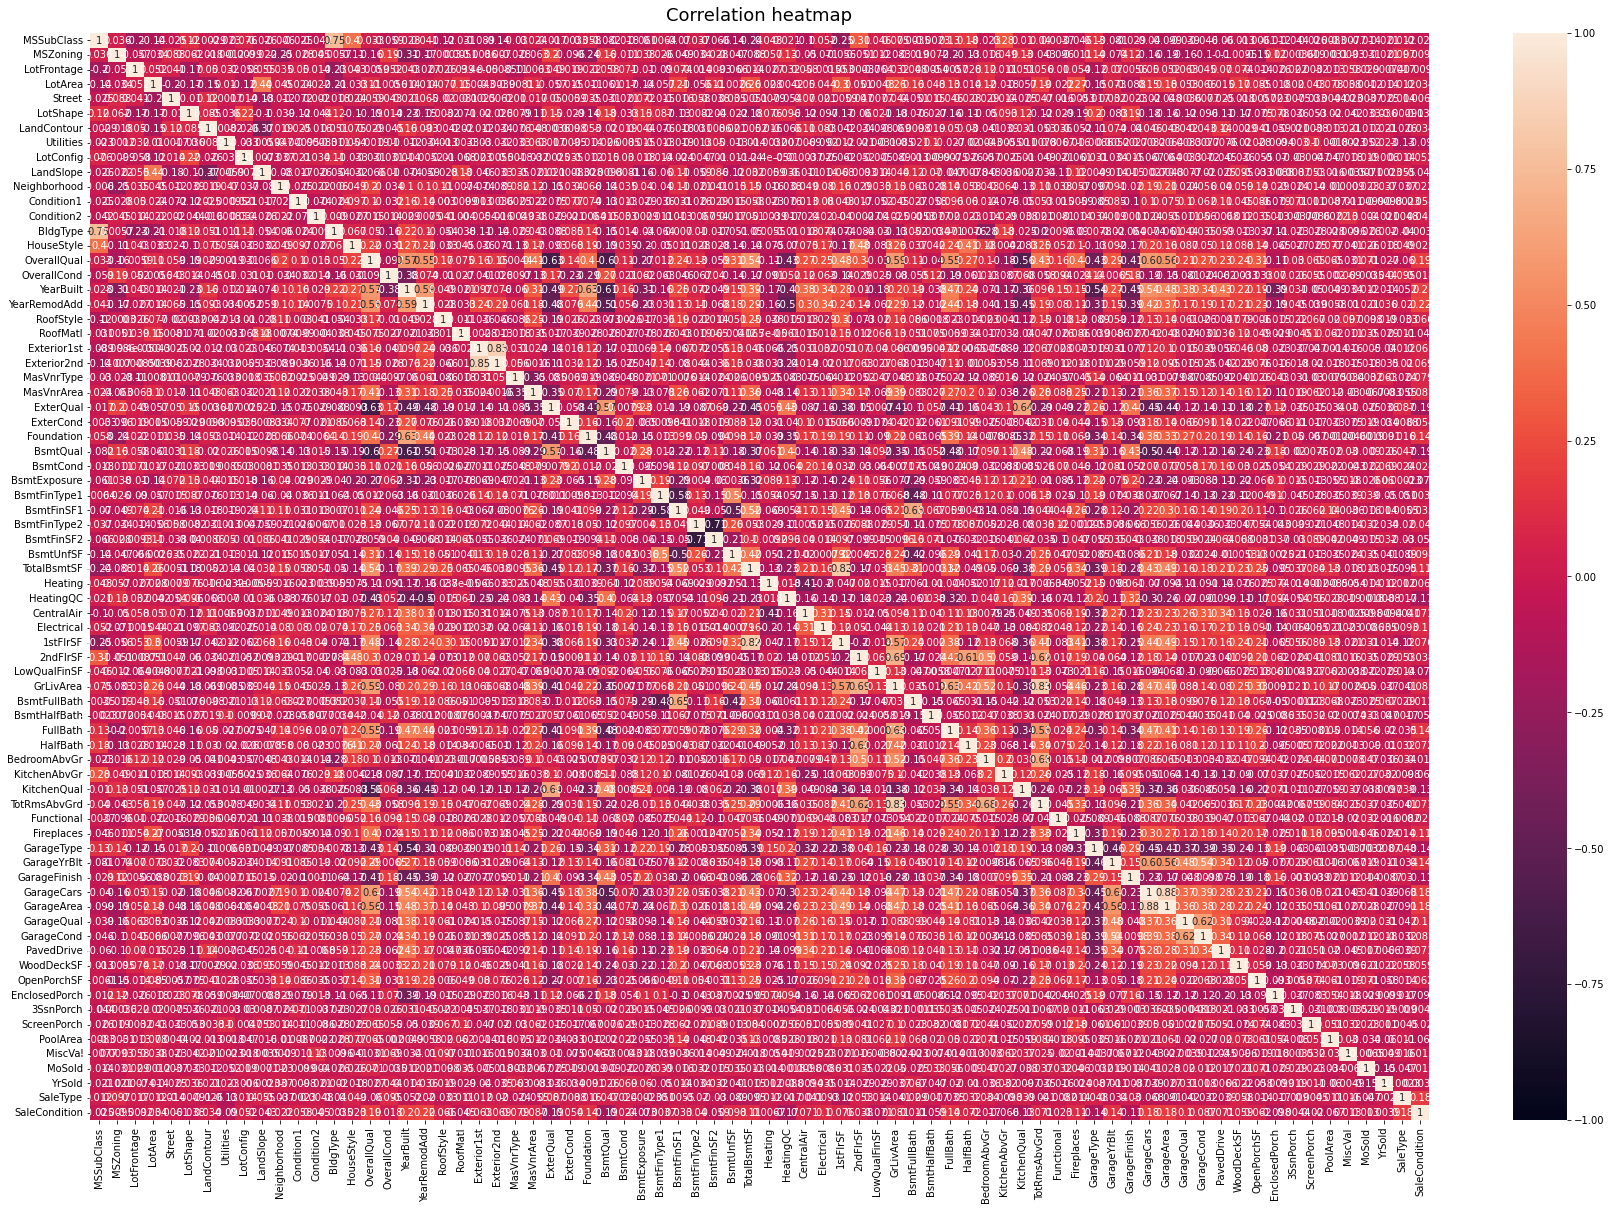

In [ ]:
plt.figure(figsize=(30, 20))

heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation heatmap', fontdict={'fontsize':18}, pad=12);

In [ ]:
correlations = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
correlations

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
MSSubClass,NaN,0.0359,-0.196391,-0.139781,-0.024969,0.119289,-0.002940,-0.022844,0.075910,-0.025672,...,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,0.012464,-0.024940
MSZoning,NaN,NaN,-0.056824,-0.034452,0.087654,0.061887,-0.017854,-0.001192,-0.009895,-0.022055,...,-0.154704,0.115509,0.000362,0.019089,-0.003128,0.009293,-0.031496,-0.020628,0.097437,0.009494
LotFrontage,NaN,NaN,NaN,0.051586,0.041156,-0.171032,0.049715,0.032472,-0.058284,0.054781,...,-0.013994,-0.025857,0.021691,0.003187,-0.013405,0.058129,0.028777,0.000736,0.017119,-0.009174
LotArea,NaN,NaN,NaN,NaN,-0.197131,-0.165315,-0.149083,0.010123,-0.121161,0.436868,...,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.012292,0.034169
Street,NaN,NaN,NaN,NaN,NaN,-0.010224,0.115995,0.001682,0.013960,-0.179360,...,-0.005664,0.023082,0.007473,-0.033160,0.004413,-0.022733,0.003690,-0.025043,0.014339,0.006064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MiscVal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.006495,0.004906,0.015773,0.013027
MoSold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.145721,-0.047386,0.013320
YrSold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002327,0.003880
SaleType,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.184067


In [ ]:
to_drop = [x for x in correlations.columns if any(correlations[x] > 0.70)]
to_drop

['BldgType', 'Exterior2nd', '1stFlrSF', 'TotRmsAbvGrd', 'GarageArea']

In [ ]:
train = train.drop(to_drop, axis=1)

#### Feature binning:


In [ ]:
train["Bath"] = train["FullBath"] + train["BsmtFullBath"] + 0.5 * (train["BsmtHalfBath"] + train["HalfBath"])
train["Porch"] = train["OpenPorchSF"] + train["EnclosedPorch"] + train["3SsnPorch"] + train["ScreenPorch"]
train["Surface"] = train["GrLivArea"] + train["TotalBsmtSF"]

In [ ]:
cols_to_drop = ["GrLivArea", "TotalBsmtSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", 
"FullBath", "BsmtFullBath", "BsmtHalfBath", "HalfBath"]

In [ ]:
train = train.drop(cols_to_drop, axis = 1)

#### Treat any time-related features as cyclical:

In [ ]:
train["SinMoSold"] = np.sin(2 * np.pi * train["MoSold"] / 12)
train["CosMoSold"] = np.cos(2 * np.pi * train["MoSold"] / 12)

train = train.drop("MoSold", axis=1)

In [ ]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PoolArea,MiscVal,YrSold,SaleType,SaleCondition,Bath,Porch,Surface,SinMoSold,CosMoSold
0,60,3,75,8450,1,3,3,0,4,0,...,0,0,2008,8,4,3.5,61,2566,8.660254e-01,5.000000e-01
1,20,3,90,9600,1,3,3,0,2,0,...,0,0,2007,8,4,2.5,0,2524,5.000000e-01,-8.660254e-01
2,60,3,78,11250,1,0,3,0,4,0,...,0,0,2008,8,4,3.5,42,2706,-1.000000e+00,-1.836970e-16
3,70,3,70,9550,1,0,3,0,0,0,...,0,0,2006,8,0,2.0,307,2473,8.660254e-01,5.000000e-01
4,60,3,94,14260,1,0,3,0,2,0,...,0,0,2008,8,4,3.5,84,3343,-2.449294e-16,1.000000e+00


#### Flatten any skew and apply StandardScaler:

In [ ]:
skew = train.skew(numeric_only = True).abs()
columns = skew[skew > 1].index

for x in columns:
    train[x] = boxcox1p(train[x], boxcox_normmax(train[x] + 1))

columns = train.select_dtypes(np.number).columns
train[columns] = StandardScaler().fit_transform(train[columns])

/shared-libs/python3.7/py/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/shared-libs/python3.7/py/lib/python3.7/site-packages/scipy/stats/stats.py:4053: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


#### Split and test: 

In [ ]:
train.shape, Y.shape

((1460, 63), (1460,))

In [ ]:
X = train
Y = Y
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 7, test_size=.3)

#### Drop outliers here if using LR:

In [ ]:
residuals = Y_train - LinearRegression().fit(X_train, Y_train).predict(X_train)
outliers = residuals[np.abs(zscore(residuals)) > 3].index

In [ ]:
print(f"Outlier columns:\n {outliers}")

Outlier columns:
 Int64Index([523, 970, 30, 688, 1298, 632, 874, 812, 714, 968, 916, 1423, 588,
            495, 803],
           dtype='int64')


In [ ]:
X_train = X_train.drop(outliers)
Y_train = Y_train.drop(outliers)

In [ ]:
rss=((Y_test - predictions) ** 2).sum()
mse=np.mean((Y_test - predictions) ** 2)

print(f"Final rmse value is: {np.sqrt(np.mean((Y_test-predictions)**2))}")

In [ ]:
ensembles = [('ScaledAdaBoost', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])),
            ('ScaledGradientBoost', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])),
            ('ScaledRandomForest', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators = 10))])),
            ('ScaledExtraTrees', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor(n_estimators = 10))]))]

In [ ]:
results = []
names = []

for name, model in ensembles:
  kfold = KFold(n_splits = 10, random_state = 7, shuffle=True)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring = "neg_mean_squared_error")
  results.append(cv_results)
  names.append(name)
  
  print(f"{name}: {round(cv_results.mean(), 5)}, {round(cv_results.std(), 5)}")
  

ScaledAdaBoost: -0.01927, 0.00415
ScaledGradientBoost: -0.01107, 0.0026
ScaledRandomForest: -0.01673, 0.00284
ScaledExtraTrees: -0.01658, 0.00309


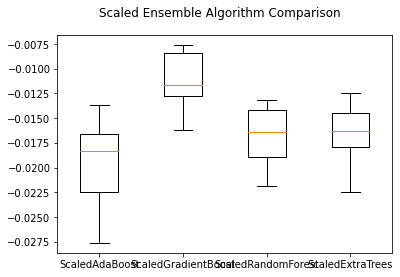

In [ ]:
fig = plt.figure()
fig.suptitle('Scaled Ensemble Algorithm Comparison') 
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
scaler = StandardScaler().fit(X_train)

rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([50,100,150,200,250,300,350,400]))
kfold = KFold(n_splits = 10, random_state = 7, shuffle=True)
grid = GridSearchCV(estimator = GradientBoostingRegressor(random_state=7), param_grid =p aram_grid, 
                    scoring="neg_mean_squared_error", cv=kfold)

grid_result = grid.fit(rescaledX, Y_train)

In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) 

Best: -0.010532 using {'n_estimators': 250}
-0.012788 (0.003002) with: {'n_estimators': 50}
-0.011069 (0.002651) with: {'n_estimators': 100}
-0.010763 (0.002428) with: {'n_estimators': 150}
-0.010614 (0.002416) with: {'n_estimators': 200}
-0.010532 (0.002326) with: {'n_estimators': 250}
-0.010601 (0.002333) with: {'n_estimators': 300}
-0.010598 (0.002347) with: {'n_estimators': 350}
-0.010614 (0.002362) with: {'n_estimators': 400}


In [ ]:
model = LinearRegression()

model.fit(X_train, Y_train)
predictions = model.predict(X_test)

print ("R^2 is: \n", model.score(X_test, Y_test))


R^2 is: 
 0.9095902793494259


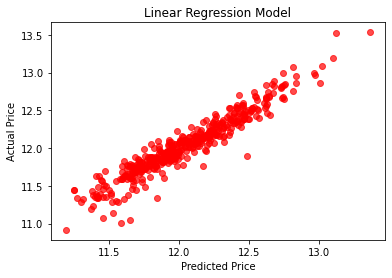

In [ ]:
plt.scatter(predictions, Y_test, alpha=.7,
            color='r') 
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d8352123-0526-41ae-8fc6-d4a9aab2194e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>